In [333]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.plan_a.transformer import MarketSampleTransformer, MarketSampleDataset
from etrade.spot.forecast.yieldindex import zero_quantile
from etrade.spot.forecast import yieldindex
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

from matplotlib import pyplot
import json

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [334]:

with open(r"..\forecast\plan_a\data\market_simulator_5.json", "r") as f:
    train_data = json.loads(f.read())
    
with open(r"..\forecast\plan_a\data\market_simulator_6.json", "r") as f:
    test_data = json.loads(f.read())

In [335]:
train_data =numpy.asarray(train_data["data"])
test_data =numpy.asarray(test_data["data"])

In [336]:
# print(train_data[:10].tolist())
print(len(train_data[0]))

155


In [337]:
# market_len = 1
# # l = 3 * market_len + market_len
# l = market_len * 126 + market_len * (5-0) * 3 + 9
l = len(train_data[0]) - 1
def zscore_p(x):
    x = numpy.asarray(x)
    m = numpy.mean(x, axis=0)
    s = numpy.std(x, ddof=1, axis=0)
    return m,s

def zscore(x, m, s):
    x = numpy.asarray(x)
    m = numpy.asarray(m)
    s = numpy.asarray(s)
    # return numpy.column_stack((
    #         (x[:,:l]-m[:l]) / s[:l], x[:,l]
    # ))
    return (x-m) / s

def minmax_p(x):
    x = numpy.asarray(x)
    mmax = numpy.max(x, axis=0)
    mmin = numpy.min(x, axis=0)
    return mmin, mmax

def minmax(x, mmin, mmax):
    x = numpy.asarray(x)
    mmin = numpy.asarray(mmin)
    mmax = numpy.asarray(mmax)
    return (x-mmin) / (mmax-mmin)
    # return numpy.column_stack((
    #         (x[:,:l]-mmin[:l]) / (mmax[:l]-mmin[:l]), x[:,l]
    # ))
    
print(l)
    

154


In [338]:
m,s= zscore_p(train_data)
zscored_t = zscore(train_data, m, s)
zscored_x = zscore(test_data, m, s)

mmin,mmax = minmax_p(train_data)
minmaxed_t = minmax(train_data, mmin, mmax)
minmaxed_x = minmax(test_data, mmin, mmax)

print(zscored_t.shape)
# print(zscored_t[:10].tolist())

(6000, 155)


In [339]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
# p = MLPRegressor(
#     hidden_layer_sizes=[50] * 4,
#     activation="relu",
#     solver="lbfgs",
#     # alpha=1e-3,
#     # learning_rate_init=1e-3
# )
p = GradientBoostingRegressor(
    # alpha=0.999
)
# p = SVR(
#     # alpha=1
# )
# p = KernelRidge()
p.fit(
    zscored_t[:,:l],
    zscored_t[:,l]
)

GradientBoostingRegressor()

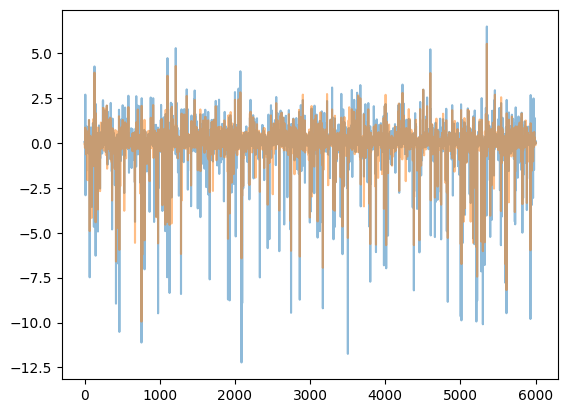

In [340]:

pyplot.plot(zscored_t[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_t[:,:l]), alpha=0.5)

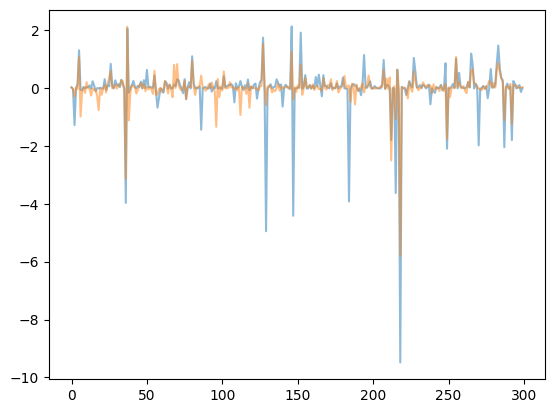

In [341]:

pyplot.plot(zscored_x[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_x[:,:l]), alpha=0.5)

In [342]:
p.score(zscored_x[:,:l], zscored_x[:,l])

0.57074215744443

In [343]:
p.score(zscored_t[:,:l], zscored_t[:,l])

0.7541473533308534

In [344]:
numpy.corrcoef(p.predict(zscored_x[:,:l]), zscored_x[:,l])

array([[1.        , 0.77560353],
       [0.77560353, 1.        ]])

In [345]:
model = MarketSampleTransformer(l, 64, 4, 2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [346]:
batch_size = 600
epoch_size = 100

zscored_t_dataset = MarketSampleDataset(zscored_t)
train_loader = DataLoader(zscored_t_dataset, batch_size=batch_size, shuffle=True)

zscored_x_dataset = MarketSampleDataset(zscored_x)
test_loader = DataLoader(zscored_x_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epoch_size):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        # batch_x, batch_y = batch_x, batch_y
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    # model.eval()
    # test_loss = 0
    # with torch.no_grad():
    #     for batch_x, batch_y in test_loader:
    #         # batch_x, batch_y = batch_x, batch_y
    #         pred = model(batch_x)
    #         loss = criterion(pred, batch_y)
    #         test_loss += loss.item() * batch_x.size(0)
    # avg_test_loss = test_loss / len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{epoch_size} | Train Loss: {avg_loss:.6f} | Test Loss: NaN")

Epoch 1/100 | Train Loss: 1.293241 | Test Loss: NaN
Epoch 2/100 | Train Loss: 0.973607 | Test Loss: NaN
Epoch 3/100 | Train Loss: 0.887232 | Test Loss: NaN
Epoch 4/100 | Train Loss: 0.844250 | Test Loss: NaN
Epoch 5/100 | Train Loss: 0.792664 | Test Loss: NaN
Epoch 6/100 | Train Loss: 0.675543 | Test Loss: NaN
Epoch 7/100 | Train Loss: 0.546108 | Test Loss: NaN
Epoch 8/100 | Train Loss: 0.458990 | Test Loss: NaN
Epoch 9/100 | Train Loss: 0.409988 | Test Loss: NaN
Epoch 10/100 | Train Loss: 0.378586 | Test Loss: NaN
Epoch 11/100 | Train Loss: 0.376255 | Test Loss: NaN
Epoch 12/100 | Train Loss: 0.359930 | Test Loss: NaN
Epoch 13/100 | Train Loss: 0.345742 | Test Loss: NaN
Epoch 14/100 | Train Loss: 0.324982 | Test Loss: NaN
Epoch 15/100 | Train Loss: 0.324501 | Test Loss: NaN
Epoch 16/100 | Train Loss: 0.285957 | Test Loss: NaN
Epoch 17/100 | Train Loss: 0.279145 | Test Loss: NaN
Epoch 18/100 | Train Loss: 0.267473 | Test Loss: NaN
Epoch 19/100 | Train Loss: 0.257849 | Test Loss: NaN
Ep

In [347]:
model.eval()
all_preds = []
all_targets = []
# 拿一批数据来预测
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        all_preds.append(preds)    # 收集预测结果
        all_targets.append(batch_y)  # 收集真实标签
        
all_preds = torch.cat(all_preds, dim=0).numpy()     # (400,)
all_targets = torch.cat(all_targets, dim=0).numpy() # (400,)

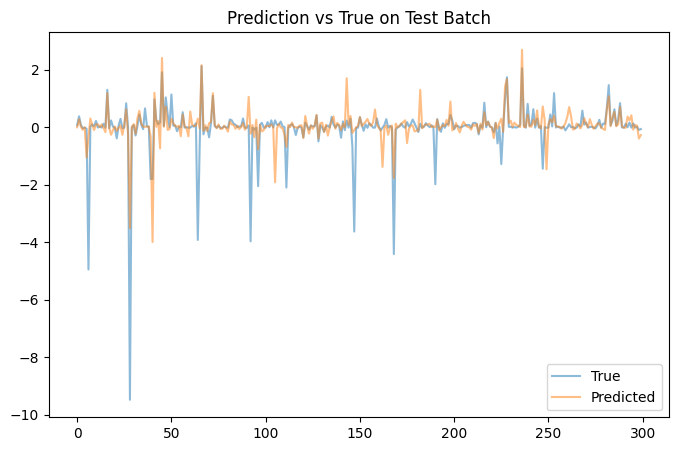

In [348]:
pyplot.figure(figsize=(8,5))
pyplot.plot(all_targets, label="True", alpha=0.5)
pyplot.plot(all_preds, label="Predicted", alpha=0.5)

pyplot.legend()
pyplot.title("Prediction vs True on Test Batch")
pyplot.show()

In [349]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

mse = root_mean_squared_error(all_targets, all_preds)
print(f"Test MSE on 600 samples: {mse:.6f}")

Test MSE on 600 samples: 0.722122


In [350]:
from sklearn.metrics import r2_score
r2 = r2_score(all_targets, all_preds)
print(f"Test R^2 on 600 samples: {r2:.6f}")

Test R^2 on 600 samples: 0.342451


In [351]:
numpy.corrcoef(all_targets, all_preds)

array([[1.       , 0.5951565],
       [0.5951565, 1.       ]])

In [352]:
print(zscored_t[:10].tolist())

[[-1.1307392200931707, -1.0997089536865712, 1.510906946508592, 0.3890757185509973, 0.25711055410354167, 0.5267265802098812, -0.8445152503676714, -0.4103756022573563, -0.2780742081870341, -0.5174649567983582, -0.7514680923533462, -0.8737784170009844, 0.1435532330223685, -0.05189499395989968, 0.6303394654556315, 0.8690977947857769, 0.03487440358311919, -0.13217119822138068, -0.20032072092809886, -0.19049213457578204, -0.19218248951626224, -0.23936709120584915, -0.31438643577829467, -0.4107197763622438, -0.5615392874391048, -0.85281764442763, 0.45942325256516137, 0.6539281344470254, 0.9870788547347537, 1.3540691812731116, 1.616119101533591, 1.6941741608027583, 1.6219631162325954, 1.4317775126554868, 1.1468368376115259, 0.8993778898806718, 0.08868556428060832, 0.4140258333901245, -0.3518231231908341, 0.6042807887407773, 1.1346768493646258, -0.7644796543262442, -0.8686049640869263, 1.1936905934690802, -0.5615656158448301, -0.550576837840454, -0.6119417570064416, -0.7158164844238158, -0.8415